# A comparison of filtering techniques for removing the oscillatory measurement errors in the encoder voltage signal (see https://gist.github.com/dougollerenshaw/4af2863494e503d2ab0d56f84ea5f25a)


Here I explore various filtering parameters and compare their effects on the running signal.

Based on the analysis below I propose two things:
* We apply a process outlined below for removing artifacts in the voltage derivative (speed) at threshold crossings
* We apply a simple Butterworth lowpass filter with a 10 Hz cutoff frequency to the resulting signal to remove the oscillatory measurement errors

Doug Ollerenshaw
dougo@alleninstitute.org
7/22/2020

# Imports

In [1]:
import visual_behavior.database as db
import visual_behavior.utilities as vbu
from visual_behavior.data_access import loading
from visual_behavior.translator.foraging2 import data_to_change_detection_core
import seaborn as sns
from scipy import signal
from scipy import stats
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from visual_behavior.encoder_processing.running_data_smoothing import process_encoder_data

import allensdk.brain_observatory.behavior.running_processing as rp
import time

import warnings
warnings.filterwarnings('ignore')

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%widescreen
%matplotlib notebook

## local function definitions

### load session and encoder (running) dataframe from session

In [3]:
def load_session(bsid):
    cache = loading.get_visual_behavior_cache()
    behavior_session_table = cache.get_behavior_session_table()
    experiment_id = db.lims_query('select id from ophys_experiments where ophys_session_id = {}'.format(int(behavior_session_table.loc[bsid]['ophys_session_id'])))
    if isinstance(experiment_id, pd.DataFrame):
        # if the session is mesoscope, there will be 8 experiment IDs returns in a dataframe. Use the 0th
        experiment_id = experiment_id.values[0][0]
    session = loading.get_ophys_dataset(experiment_id)
    return session

def load_session_and_running_df(bsid):
    session = load_session(bsid)
    running_df = session.running_data_df.reset_index().rename(columns={'timestamps':'time'}) #encoder_utilities.load_running_df(bsid)
    return session, running_df

In [4]:
session = load_session(bsid = 852440775)
session.running_data_df.reset_index()

,timestamps,speed,dx,v_sig,v_in
0,7.314303,25.022575,-47.735771,3.429044,4.989814
1,7.331083,25.082509,4.371402,3.483310,4.980770
2,7.347783,28.586295,5.855837,3.569875,4.988522
3,7.364463,32.915934,5.562266,3.642229,4.982062
4,7.381103,32.964086,2.667241,3.684866,4.989814
...,...,...,...,...,...
269931,4510.604433,0.439994,-0.464628,1.668011,4.978186
269932,4510.621233,0.445982,0.373735,1.673179,4.978186
269933,4510.637783,1.240996,0.215495,1.679639,4.988522
269934,4510.654593,0.615662,-0.339620,1.670595,4.975602


In [5]:
%%time
rd = process_encoder_data(session.running_data_df.reset_index())

CPU times: user 42.1 s, sys: 1.06 s, total: 43.1 s
Wall time: 27.3 s


In [6]:
rd

,timestamps,speed,v_sig,v_in,wrap_ID,v_sig_unwrapped,speed_raw,speed_raw_pre_wrap_correction,acceleration,jerk
0,7.314303,-0.007387,3.429044,4.989814,0,NaN,NaN,NaN,NaN,NaN
1,7.331083,3.060593,3.483310,4.980770,0,3.483310,NaN,NaN,182.835558,NaN
2,7.347783,8.995100,3.569875,4.988522,0,3.569875,NaN,NaN,355.359698,10330.786779
3,7.364463,17.415583,3.642229,4.982062,0,3.642229,30.224080,30.224080,504.825093,8960.755147
4,7.381103,25.147342,3.684866,4.989814,0,3.684866,17.853433,17.853433,464.649010,-2414.428084
...,...,...,...,...,...,...,...,...,...,...
269931,4510.604433,-0.508450,1.668011,4.978186,0,21354.699148,-4.309974,-4.309974,-11.518002,497.030050
269932,4510.621233,-0.411538,1.673179,4.978186,0,21354.704316,2.143442,2.143442,5.768590,1028.963832
269933,4510.637783,0.083145,1.679639,4.988522,0,21354.710776,2.719776,2.719776,29.890215,1457.499996
269934,4510.654593,1.142871,1.670595,4.975602,0,21354.701732,-3.748793,-3.748793,63.041369,1972.109107


<IPython.core.display.Javascript object>


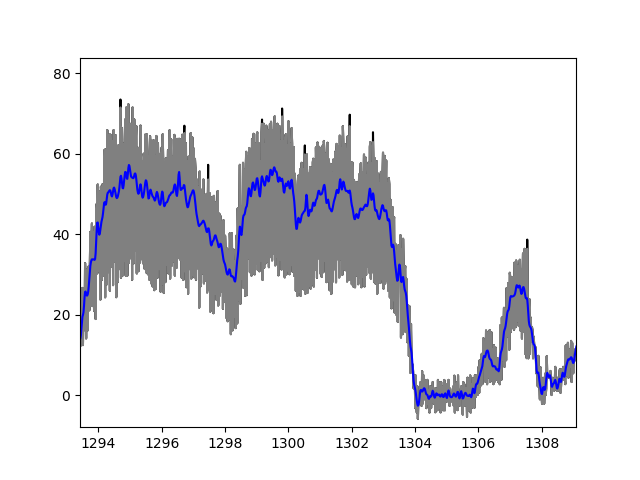

In [7]:
fig,ax=plt.subplots()
ax.plot(
    rd['timestamps'],
    rd['speed_raw_pre_wrap_correction'],
    color='black'
)
ax.plot(
    rd['timestamps'],
    rd['speed_raw'],
    color='gray'
)
ax.plot(
    rd['timestamps'],
    rd['speed'],
    color='blue'
)

In [29]:
rd.drop(columns = ['dx']) if 'dx' in rd.columns else rd

,timestamps,speed,v_sig,v_in,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped,speed_raw,wrap_bool,speed_raw_pre_wrap_correction,zscored_speed_raw,acceleration_raw,jerk_raw
0,7.314303,-0.007387,3.429044,4.989814,NaN,0,NaN,NaN,NaN,False,NaN,0.000000,NaN,NaN
1,7.331083,3.060593,3.483310,4.980770,3.429044,0,0.054265,3.483310,NaN,False,NaN,0.000000,NaN,NaN
2,7.347783,8.995100,3.569875,4.988522,3.483310,0,0.086566,3.569875,NaN,False,NaN,0.000000,NaN,NaN
3,7.364463,17.415583,3.642229,4.982062,3.569875,0,0.072354,3.642229,30.224080,False,30.224080,-0.124553,NaN,NaN
4,7.381103,25.147342,3.684866,4.989814,3.642229,0,0.042637,3.684866,17.853433,False,17.853433,-0.676961,-743.428336,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269931,4510.604433,-0.508450,1.668011,4.978186,1.678347,0,-0.010336,21354.699148,-4.309974,False,-4.309974,-1.666662,-257.927827,-1856.402241
269932,4510.621233,-0.411538,1.673179,4.978186,1.668011,0,0.005168,21354.704316,2.143442,False,2.143442,-1.378486,384.131929,38217.842587
269933,4510.637783,0.083145,1.679639,4.988522,1.673179,0,0.006460,21354.710776,2.719776,False,2.719776,-1.352750,34.823774,-21106.232915
269934,4510.654593,1.142871,1.670595,4.975602,1.679639,0,-0.009044,21354.701732,-3.748793,False,-3.748793,-1.641602,-384.804800,-24963.032358


### functions for processing encoder data prior to filtering

In [4]:
def add_columns_and_unwrap(df, v_max='v_sig_max'):
    '''
    add columns to the running dataframe representing:
        v_sig_last: shifted voltage signal
        wrap_ID: 1 for postive wraps, -1 for negative wraps, 0 otherwise
        v_sig_diff: voltage derivative, after accounting for wraps
        v_sig_unwrapped: the cumulative voltage signal (no longer bounded by 0 to 5V)
    inputs:
        running_dataframe (with columns 'time', 'v_in', 'v_sig')
        v_max - the value to use as the max voltage before the encoder 'wraps' back to 0V
                       'v_in' uses the measured input voltage
                       'v_sig_max' (default) uses the maximum observed voltage in the 'v_sig' column

    '''
    if v_max == 'v_sig_max':
        threshold = 5.1  # just in case some outlier got into the data, voltage should never exceed ~5V
        v_max = df[df['v_sig'] < threshold]['v_sig'].max()

    df['v_sig_last'] = df['v_sig'].shift()
    df['wrap_ID'] = df.apply(identify_wraps, axis=1)
    df['v_sig_diff'] = df.apply(calculate_wrap_corrected_diff, axis=1, nan_transitions=False, v_max=v_max)
    df['v_sig_unwrapped'] = np.cumsum(df['v_sig_diff']) + df['v_sig'].iloc[0]

    return df

def identify_wraps(row, lower_threshold=1.5, upper_threshold=3.5):
    '''
    identify "wraps" in the voltage signal as any point where the crosses from 5V to 0V or vice-versa
    '''
    if row['v_sig'] < lower_threshold and row['v_sig_last'] > upper_threshold:
        return 1  # positive wrap
    elif row['v_sig'] > upper_threshold and row['v_sig_last'] < lower_threshold:
        return -1  # negative wrap
    else:
        return 0


def calculate_wrap_corrected_diff(row, max_diff=1, nan_transitions=False, v_max='v_in'):
    '''
    calculate the change in voltage at each timestep, accounting for the wraps.
    '''
    if v_max == 'v_in':
        v_max = row['v_in']

    if row['wrap_ID'] == 1:
        # unrwap the current value, subtract the last valueif nan_transitions:
        if nan_transitions:
            diff = np.nan
        else:
            diff = (row['v_sig'] + v_max) - row['v_sig_last']
    elif row['wrap_ID'] == -1:
        # unwrap the last value, subtract it from the current value
        if nan_transitions:
            diff = np.nan
        else:
            diff = row['v_sig'] - (row['v_sig_last'] + v_max)
    else:
        diff = row['v_sig'] - row['v_sig_last']

    if np.abs(diff) > max_diff:
        return np.nan
    else:
        return diff

def calculate_derivative(df, column_to_differentiate, time_column='time'):
    '''a simple derivative function'''
    return df[column_to_differentiate].diff()/df[time_column].diff()
    # return np.gradient(df[column_to_differentiate], df[time_column])


def calculate_speed(df, voltage_column, time_column='time'):
    '''a function to calculate speed from the voltage signal'''
    delta_theta = df[voltage_column].diff() / df['v_in'] * 2 * np.pi  # delta theta at each step in radians

    wheel_diameter = 6.5 * 2.54  # 6.5" wheel diameter
    running_radius = 0.5 * (2.0 * wheel_diameter / 3.0)  # assume the animal runs at 2/3 the distance from the wheel center

    df_temp = pd.DataFrame({'time': df[time_column], 'theta_cumulative': np.cumsum(delta_theta)})

    speed = calculate_derivative(df_temp, column_to_differentiate='theta_cumulative', time_column=time_column) * running_radius  # linear speed in cm/s

    return speed

def remove_outliers(df_in, column_to_filter, boolean_col, t_span, time_column='time'):
    '''
    removes potential outliers using the following algorithm
        * operates only on 'column_to_filter'
        * For every value where 'boolean_col' is True:
            * identifies all values in time range of +/- t_span, excluding any other rows where 'boolean_col' is True
            * If value is greater than any other values in the range, sets value to max of other values in range
            * If values is less than any other values in range, sets value to min of other values in range

    Thus, possible outliers are identified in advance aand are not allowed to exceed range identifed by other values
    that have not been identified as outliers
    '''
    df = df_in.copy()
    df['outlier_removed'] = df[column_to_filter]
    df_to_filter = df[df[boolean_col]]
    for idx,row in df_to_filter.iterrows():
        t_now = row[time_column]
        local_vals = df.query('{0} >= @t_now - @t_span and {0} <= @t_now + @t_span and {1} == False'.format(time_column, boolean_col))[column_to_filter]
        df.at[idx, 'outlier_removed'] = np.clip(df.at[idx, column_to_filter],np.nanmin(local_vals),np.nanmax(local_vals))
        
    return df['outlier_removed']

def add_speed_acceleration_jerk(df_in, column_label, voltage_column='v_sig_unwrapped', v_max='v_sig_max', remove_outliers_at_wraps=True,zscore_thresold=5):
    '''
    add columns for speed (cm/s), acceleration (cm/s^2) and jerk (cm/s^3) to the dataframe
    inputs:
        df_in (dataframe): encoder dataframe with (at minimum) columns for v_in and v_sig
        column_label (string): what to call the output columns (default = 'raw', eg. speed_raw, acceleration_raw, jerk_raw) 
        voltage_column (string): the column on which to calculate derivative to calculate speed
        v_max (string): how maxiumum encoder voltage should be defined. See add_columns_and_unwrap for detailed explanation. (default = 'v_sig_max')
        remove_outliers_at_wrap (boolean): If True, ensures that velocity at voltage wrap does not exceed range of velocities in nearby +/- 0.25 second window (default = True)
        zscore_threshold (float): any remaining velocity values that are more than `zscore_threshold` SDs from the mean will be replaced with NaN (default = 5)
    returns:
        a new dataframe with additional columns
    '''
    df_in = add_columns_and_unwrap(df_in, v_max=v_max)
    speed_label = 'speed_{}'.format(column_label)
    df_in[speed_label] = calculate_speed(df_in, voltage_column=voltage_column)

    if remove_outliers_at_wraps:
        df_in['wrap_bool'] = df_in['wrap_ID'] != 0
        df_in[speed_label+'_pre_wrap_correction'] = df_in[speed_label]
        df_in[speed_label] = remove_outliers(
            df_in, 
            speed_label, 
            'wrap_bool', 
            t_span=0.25
        )

    ## replace any values that exceed the z-score threshold with NaN
    df_in['zscored_speed_{}'.format(column_label)] = stats.zscore(
        df_in[speed_label].fillna(df_in[speed_label].mean())
    )
    df_in.loc[
        df_in[df_in['zscored_speed_{}'.format(column_label)].abs() >= zscore_thresold].index.values,
        speed_label
    ] = np.nan
    
    df_in['acceleration_{}'.format(column_label)] = calculate_derivative(df_in, 'speed_raw')
    df_in['jerk_{}'.format(column_label)] = calculate_derivative(df_in, 'acceleration_raw')
    return df_in

### make a plot of the basic signals in the running data, additional timeseries can be plotted on top of these axes for comparison

In [5]:
def make_raw_plot(df_in,figsize=(15,25)):
    fig,ax=plt.subplots(4,1,figsize=figsize, sharex=True)
    ax[0].plot(
        df_in['time'],
        df_in['time'].diff(),
        color='black',
        marker='.'
    )
    ax[0].set_title('time diffs')
    ax[0].set_ylabel('seconds')
    
    ax[1].plot(
        df_in['time'],
        df_in['v_sig'],
        '-r',
        marker='.'
    )
    ax[1].plot(
        df_in['time'],
        df_in['v_in'],
        '-b'
    )
    ax[1].axhline(0)
    ax[1].set_title('raw encoder voltages')
    ax[1].set_ylabel('voltage')
    
    ax[2].plot(
        df_in['time'],
        df_in['v_sig_unwrapped'],
        marker='.'
    )
    ax[2].set_title('unwrapped encoder voltage')
    ax[2].set_ylabel('voltage')

    ax[3].plot(
        df_in['time'],
        df_in['speed_raw_pre_wrap_correction'],
        color='black',
    )
    ax[3].plot(
        df_in['time'],
        df_in['speed_raw'],
        color='gray'
    )
    ax[3].set_title('calculated speed')
    ax[3].set_ylabel('speed (cm/s)')
    ax[3].set_xlabel('time (s)')
            
    fig.tight_layout()
            
    return fig,ax




### calculate and plot discrete FFT

In [6]:
import scipy
def FFT(t,y,sampling_rate,subtract_dc=True,):
    """
    calculate FFT from 0 to Nyquist
    """
    if subtract_dc == True:
        y = y-np.mean(y)

    N = int(np.max(t)*sampling_rate)
    yf = scipy.fft.fft(y)
    tf = np.linspace(0.0, sampling_rate/(2.0), int(N/2))

    F = tf #frequencies, from 0 to the Nyquist
    P = 2.0/N * np.abs(yf[0:int(N/2)]) #Power at each value F

    return F,P

def plot_fft(df, column_to_fft):
    F,P =FFT(
        running_df.dropna()['time'].values,
        running_df.dropna()['speed_raw'].values,
        sampling_rate=1/running_df['time'].diff().median(),
    )
    
    fig,ax=plt.subplots(2,1,sharex=True,figsize=(10,10))
    ax[0].plot(F,P)
    ax[1].semilogy(F,P)
    ax[0].set_title('FFT of running signal')
    ax[0].set_ylabel('power (a.u.)')
    ax[1].set_title('FFT of running signal, log y-axis')
    ax[1].set_ylabel('log(power) (a.u.)')
    ax[1].set_xlabel('frequency (Hz)')
    fig.tight_layout()
    return fig,ax

### method for applying basic lowpass filters to the running trace

In [7]:
def apply_filters(running_df, cutoffs = [1,2,5,8,10,15,20]):
    filter_names=[]
    N=3
    for cutoff in cutoffs:
        b, a = signal.butter(N, Wn=cutoff, fs=60, btype='lowpass')
        filter_name = 'speed_butterworth_N={}_cutoff={:0>2d}Hz'.format(N,cutoff)
        filter_names.append(filter_name)
        running_df[filter_name] = signal.filtfilt(b, a, running_df['speed_raw'].fillna(0))
    return running_df, filter_names

### a method for generating an event-triggered running plot to compare various filtering scenarios

In [8]:
def event_triggered_running_response(session, running_df, speed_column, event_type):

    change_times = session.trials.query(event_type)['change_time']
    etr = vbu.event_triggered_response(
        df = running_df,
        parameter = speed_column,
        event_times = change_times
    )
    x_value = 'time'
    y_values = [col for col in etr.columns if col != 'time']
    var_name = 'line'
    value_name = 'value'
    df_melted = pd.melt(
            etr,
            id_vars=[x_value],
            value_vars=y_values,
            var_name='event_name',
            value_name='running_speed'
        )
    df_melted['speed_type'] = speed_column
    df_melted['event_type'] = event_type
    return df_melted

def get_combined_etr(session, running_df, filter_names, event_types=['hit','correct_reject']):
    melted_etr = []
    for speed_column in ['speed_raw']+filter_names:
        for event_type in event_types:
            melted_etr.append(event_triggered_running_response(
                session,
                running_df = running_df,
                speed_column = speed_column,
                event_type = event_type,
            ))
    melted_etr = pd.concat(melted_etr)
    return melted_etr

### a method for plotting the event triggered responses

In [9]:
def plot_change_triggered_responses(etr_df_to_plot, p_value_df_to_plot, time_range):
    ti,tf = time_range
    fig,ax=plt.subplots(3,1,figsize=(11,11),sharex=True)
    f1 = sns.lineplot(
        data=etr_df_to_plot.query('time >= @ti and time <= @tf and event_type in ["hit","correct_reject"]'),
        x='time',
        y='running_speed',
        hue = 'speed_type',
        style='event_type',
        n_boot=50,
        ax=ax[0],
    )
    ax[0].set_title('change triggered running responses with confidence intervals')
    f2 = sns.lineplot(
        data=etr_df_to_plot.query('time >= @ti and time <= @tf and event_type in ["hit","correct_reject"]'),
        x='time',
        y='running_speed',
        hue = 'speed_type',
        style='event_type',
        ci=None,
        ax=ax[1],
        legend=False
    )
    ax[1].set_title('change triggered running responses without confidence intervals')
    
    speed_types = etr_df_to_plot['speed_type'].unique()
    ax[2].axhline(0.05,color='black')
    ax[2].axhline(0.01,color='red')
    sns.lineplot(
        data=p_value_df_to_plot.query('time >= @ti and time <= @tf'),
        x='time',
        y='p_value',
        hue='speed_type',
        ax=ax[2],
        legend=False,
    )
    ax[2].legend(['p = 0.05','p = 0.01'])
    ax[2].set_title('p values vs. time for hit/cr running curves')

    for i in range(3):
        ax[i].axvline(0)
        
    fig.tight_layout()
    
    return fig,ax

### a method for calculating the p-values (using a simple independent t-test) for the hit and correct-reject running traces at each timepoint

In [10]:
from multiprocessing import Pool
def running_diff_test(time, df_in, speed_type, v1, v2):
    query_string = 'time == @time and speed_type == @speed_type and event_type =="{}"'
    d1 = df_in.query(query_string.format(v1))
    d2 = df_in.query(query_string.format(v2))
    p_value = stats.ttest_ind(d1['running_speed'],d2['running_speed'])[1]
    return {'time':time, 'speed_type':speed_type, 'p_value':p_value}

def get_p_values_at_each_timepoint(df_in, groupby, condition_1, condition_2):
    times = df_in['time'].unique()
    
    for event_type in [condition_1, condition_2]:
        df_in[event_type] = df_in['event_type'].apply(lambda et:et==event_type)
        
    params = []
    for grp in df_in[groupby].unique():
        params += [[t, df_in, grp, condition_1, condition_2] for t in times]
        
    with Pool(32) as pool:
        ans = pool.starmap(running_diff_test, params)
    return pd.DataFrame(ans)

# Look at some some example sessions

### load data, apply filters

In [11]:
%%time
bsid = 852440775
session, running_df = load_session_and_running_df(bsid)
running_df = add_speed_acceleration_jerk(running_df, column_label='raw',v_max='v_sig_max')
running_df, filter_names = apply_filters(running_df)

CPU times: user 43.6 s, sys: 1.23 s, total: 44.9 s
Wall time: 29.6 s


In [12]:
np.sort(filter_names)

array(['speed_butterworth_N=3_cutoff=01Hz',
       'speed_butterworth_N=3_cutoff=02Hz',
       'speed_butterworth_N=3_cutoff=05Hz',
       'speed_butterworth_N=3_cutoff=08Hz',
       'speed_butterworth_N=3_cutoff=10Hz',
       'speed_butterworth_N=3_cutoff=15Hz',
       'speed_butterworth_N=3_cutoff=20Hz'], dtype='<U33')

In [13]:
running_df

,time,speed,dx,v_sig,v_in,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped,speed_raw,wrap_bool,speed_raw_pre_wrap_correction,zscored_speed_raw,acceleration_raw,jerk_raw,speed_butterworth_N=3_cutoff=01Hz,speed_butterworth_N=3_cutoff=02Hz,speed_butterworth_N=3_cutoff=05Hz,speed_butterworth_N=3_cutoff=08Hz,speed_butterworth_N=3_cutoff=10Hz,speed_butterworth_N=3_cutoff=15Hz,speed_butterworth_N=3_cutoff=20Hz
0,7.314303,25.022575,-47.735771,3.429044,4.989814,NaN,0,NaN,NaN,NaN,False,NaN,3.186720e-16,NaN,NaN,-0.473495,0.186284,-0.086509,0.016972,-0.007429,-0.000130,0.010059
1,7.331083,25.082509,4.371402,3.483310,4.980770,3.429044,0,0.054265,3.483310,NaN,False,NaN,3.186720e-16,NaN,NaN,1.468311,3.734009,6.148767,4.992501,3.056291,-0.771067,-4.363754
2,7.347783,28.586295,5.855837,3.569875,4.988522,3.483310,0,0.086566,3.569875,NaN,False,NaN,3.186720e-16,NaN,NaN,3.392735,7.190630,12.144680,10.888351,8.965892,6.433159,8.040238
3,7.364463,32.915934,5.562266,3.642229,4.982062,3.569875,0,0.072354,3.642229,30.106507,False,30.106507,-1.239829e-01,NaN,NaN,5.289877,10.495038,17.598630,17.488614,17.343770,18.335404,20.904449
4,7.381103,32.964086,2.667241,3.684866,4.989814,3.642229,0,0.042637,3.684866,17.756353,False,17.756353,-6.778762e-01,-742.196777,NaN,7.150169,13.592224,22.192932,23.491507,25.036675,27.765838,24.111263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269931,4510.604433,0.439994,-0.464628,1.668011,4.978186,1.678347,0,-0.010336,21354.699148,-4.296551,False,-4.296551,-1.666929e+00,-257.124522,-1875.169224,0.751521,1.316590,-0.074230,-0.509643,-0.508324,-0.639962,-3.283119
269932,4510.621233,0.445982,0.373735,1.673179,4.978186,1.668011,0,0.005168,21354.704316,2.136767,False,2.136767,-1.378401e+00,382.935567,38098.814861,0.780168,1.578911,0.330467,-0.353082,-0.412021,0.136648,1.590874
269933,4510.637783,1.240996,0.215495,1.679639,4.988522,1.673179,0,0.006460,21354.710776,2.705687,False,2.705687,-1.352885e+00,34.375871,-21061.008832,0.806486,1.846305,0.959328,0.251074,0.080977,0.121496,1.976454
269934,4510.654593,0.615662,-0.339620,1.670595,4.975602,1.679639,0,-0.009044,21354.701732,-3.739058,False,-3.739058,-1.641926e+00,-383.387606,-24852.080728,0.830268,2.111605,1.780167,1.322233,1.137268,0.213750,-2.675802


### plot the basic signals for a 10 second period

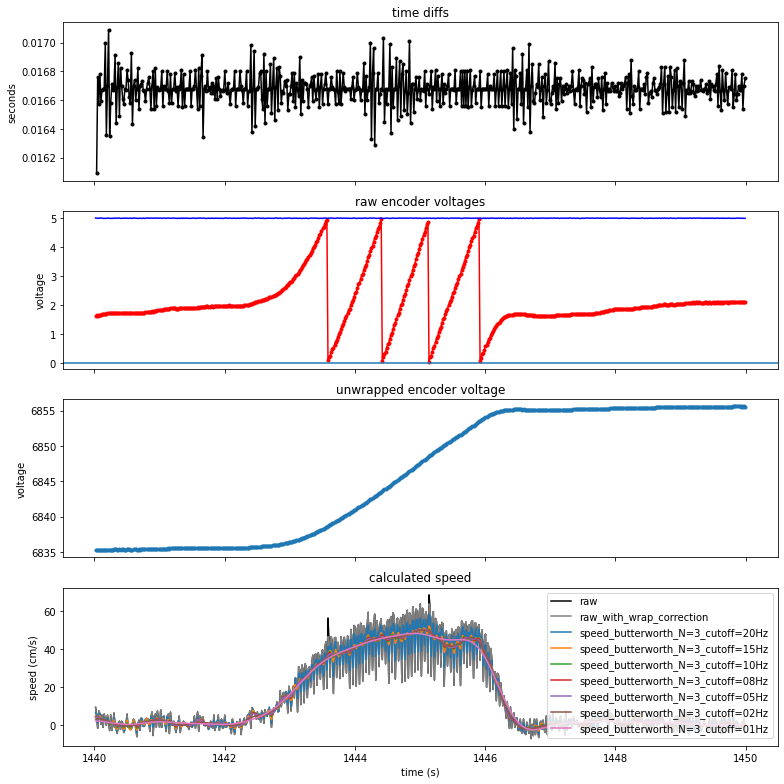

In [14]:
dft = running_df.query('time>=1440 and time <= 1450')
fig,ax = make_raw_plot(dft, figsize=(11,11))

legend = ['raw','raw_with_wrap_correction']
for filter_name in np.sort(filter_names)[::-1]:
    ax[3].plot(
        dft['time'],
        dft[filter_name],
    )
    legend.append(filter_name)
ax[3].legend(legend);
fig.tight_layout()


### zoom in on a tighter time window

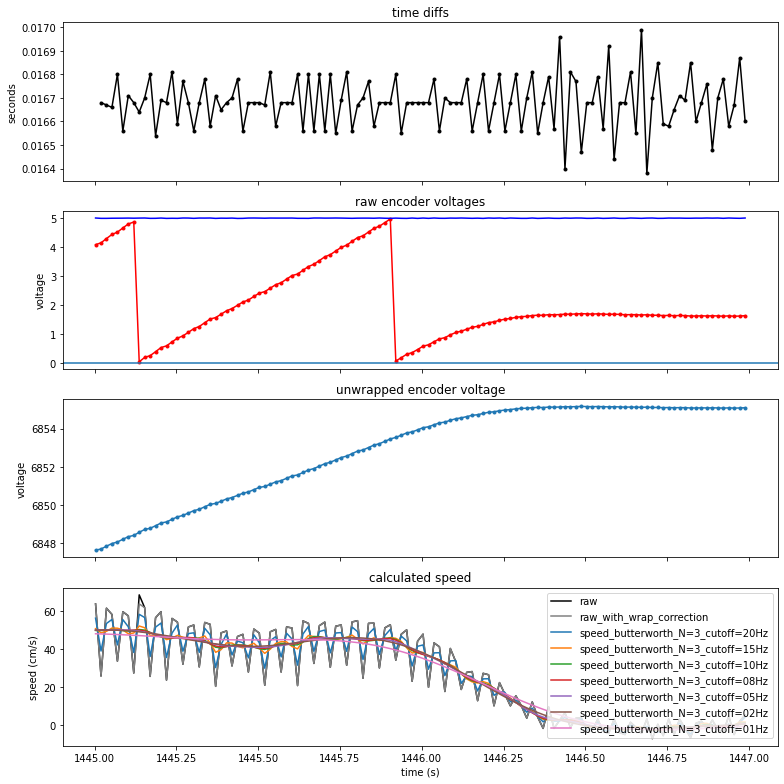

In [15]:
dft = running_df.query('time>=1445 and time <= 1447')
fig,ax = make_raw_plot(dft, figsize=(11,11))

legend = ['raw','raw_with_wrap_correction']
for filter_name in np.sort(filter_names)[::-1]:
    ax[3].plot(
        dft['time'],
        dft[filter_name],
    )
    legend.append(filter_name)
ax[3].legend(legend);
fig.tight_layout()

### here is another point in time with a clear measurement error that is mostly corrrected with the outlier removal algorithm (though note that there is still a residual dip in the filtered signals)

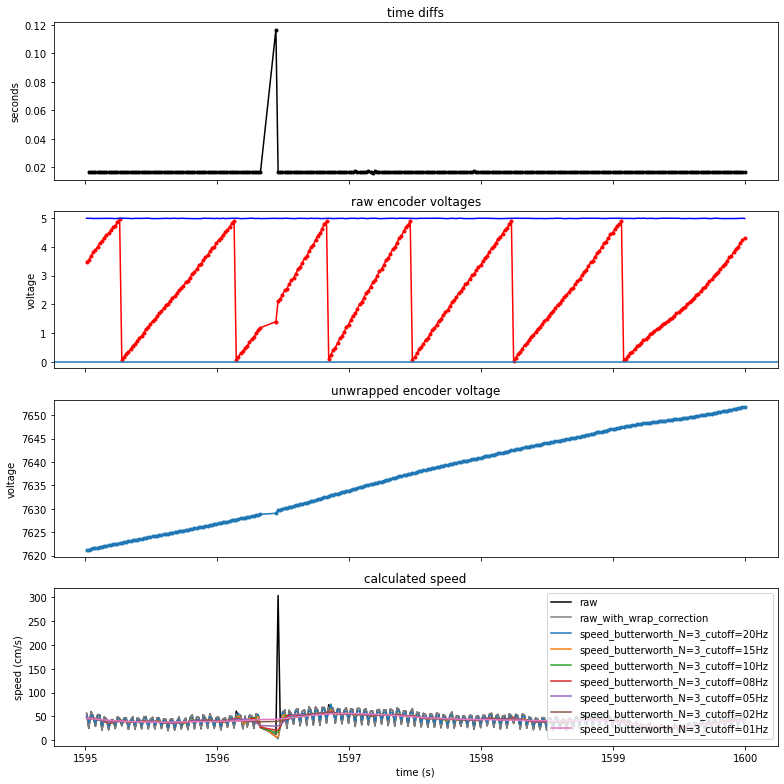

In [16]:
dft = running_df.query('time>1595 and time<1600')
fig,ax = make_raw_plot(dft, figsize=(11,11))

legend = ['raw','raw_with_wrap_correction']
for filter_name in np.sort(filter_names)[::-1]:
    ax[3].plot(
        dft['time'],
        dft[filter_name],
    )
    legend.append(filter_name)
ax[3].legend(legend,loc='upper right');
fig.tight_layout()

### note the strong peak in the 20 Hz range in fourier space. This is due to periodic nature of the measurement error: every third measurement is an underestimate of the actual voltage (and thus speed)

### this argues using a low-pass filter with a cutoff frequency no higher than ~10-15 Hz

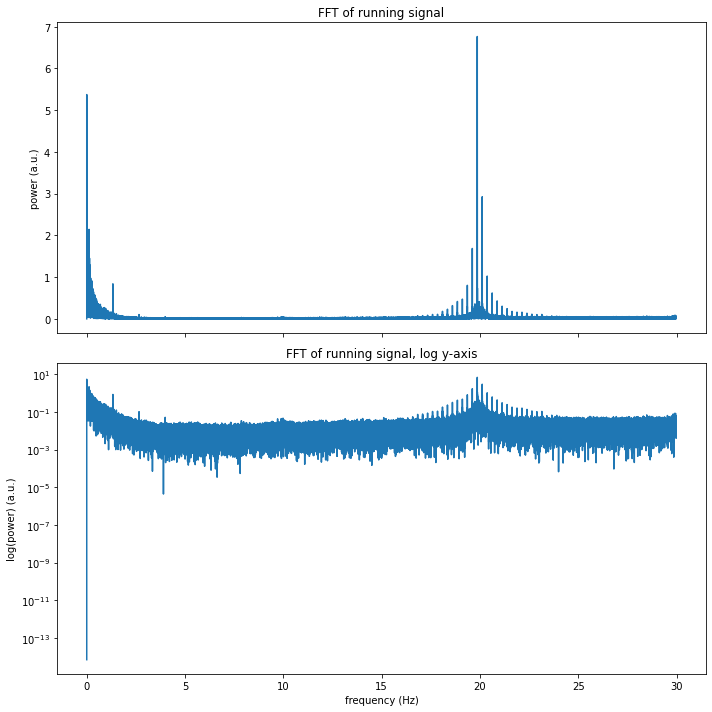

In [17]:
plot_fft(running_df, 'speed_raw');

### now look at event triggered responses on hit and correct-rejection trials. Do any of the filters have the possibility of changing our interpration of when animals begins to slow on hit trials (vs CR trials, when animals tend not to slow)?

In [18]:
etr_df = get_combined_etr(session, running_df, filter_names)

In [19]:
%%time
p_value_df = get_p_values_at_each_timepoint(etr_df, groupby='speed_type', condition_1='hit', condition_2='correct_reject')

CPU times: user 17.3 s, sys: 3.37 s, total: 20.6 s
Wall time: 41.7 s


(<Figure size 792x792 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6b7588df0>,
       dtype=object))

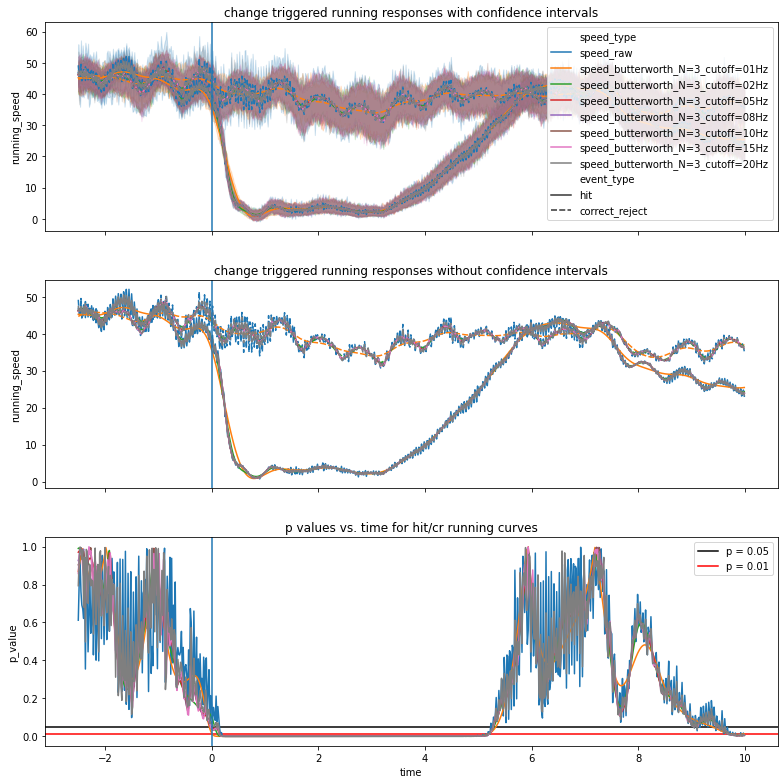

In [20]:
plot_change_triggered_responses(etr_df, p_value_df, time_range=(-2.5,10))

(<Figure size 792x792 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6b764cdc0>,
       dtype=object))

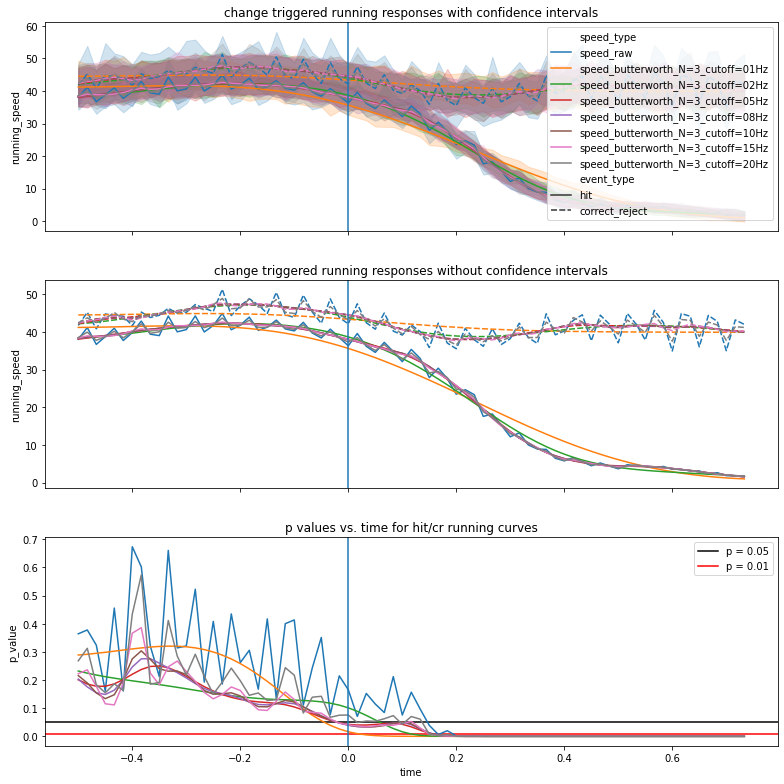

In [21]:
plot_change_triggered_responses(etr_df, p_value_df, time_range=(-0.5,0.75))

## Conclusion from above:
* a low-pass filter with a 5 or 10 Hz cu

## Identify some more sessions to analyze
### count hit and correct_reject trials. Choose a few sessions with plenty of both

In [22]:
cache = loading.get_visual_behavior_cache()
behavior_session_table = cache.get_behavior_session_table()

In [23]:
len(behavior_session_table)

10187

In [24]:
session_sample = behavior_session_table[pd.notnull(behavior_session_table['ophys_session_id'])].sample(10,random_state=0).reset_index()
session_sample

,behavior_session_id,ophys_session_id,behavior_training_id,equipment_name,date_of_acquisition,donor_id,full_genotype,reporter_line,driver_line,sex,age_in_days,foraging_id,session_type
0,882669474,882620042.0,NaN,CAM2P.3,2019-06-07 08:49:13.158,830940312,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,[Ai94(TITL-GCaMP6s)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",M,138.0,5451d134-776b-48b3-a06c-05a30c00b5ce,OPHYS_6_images_B
1,853875514,853773937.0,NaN,CAM2P.4,2019-04-18 13:59:55.497,823826963,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",F,96.0,5a81320b-c871-4239-a26c-e23c3a26ddf7,OPHYS_4_images_B
2,877617747,877525291.0,NaN,CAM2P.3,2019-05-29 13:16:57.701,834823464,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",F,124.0,52e56d15-2aa3-42d7-8ce5-f95df0d30801,OPHYS_3_images_A
3,929818797,929686773.0,NaN,MESO.1,2019-08-23 08:48:05.598,840355560,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Vip-IRES-Cre],M,196.0,b47f1238-efb3-4d93-888c-77231bf1b93f,OPHYS_1_images_A
4,993780754,993738515.0,NaN,MESO.1,2019-12-11 11:47:40.153,935565377,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",M,153.0,09c10c0e-54dd-46bb-8912-1cabb6b6d759,OPHYS_4_images_B
5,883477472,883352686.0,NaN,CAM2P.4,2019-06-10 08:47:58.464,830896318,Chat-IRES-Cre-neo/wt;Ai162(TIT2L-GC6s-ICL-tTA2...,[Ai162(TIT2L-GC6s-ICL-tTA2)],[Chat-IRES-Cre-neo],M,175.0,a73cc421-ded0-4f91-8587-300dffdb7669,OPHYS_2_images_A_passive
6,823998659,823931897.0,NaN,CAM2P.5,NaN,789992895,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,[Ai93(TITL-GCaMP6f)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",M,NaN,749daa2e-d56c-4c39-a38f-9a2f59caf7a8,NaN
7,875471358,875259383.0,NaN,MESO.1,2019-05-24 13:30:24.606,837628429,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Vip-IRES-Cre],M,126.0,ec7823b3-00aa-46c1-8f93-a1d57560f663,OPHYS_6_images_A
8,768881602,729218705.0,NaN,CAM2P.5,2018-08-02 12:13:08.114,667397351,Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,[Ai93(TITL-GCaMP6f)],"[Rbp4-Cre_KL100, Camk2a-tTA]",F,207.0,e2d88195-882c-5577-a4f7-0b1a4e7f9e7c,1_gratings
9,865277684,865024413.0,NaN,MESO.1,2019-05-09 09:56:04.176,831008730,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Sst-IRES-Cre],F,116.0,fc8f8a52-fca4-4acd-8537-5160e703c1f0,OPHYS_3_images_A


In [25]:
def count_trial_types(bsid):
    t0=time.time()
    trial_count = {'behavior_session_id':bsid}
    try:
        session = load_session(bsid)
        for trial_type in ['hit','miss','false_alarm','correct_reject']:
            trial_count[trial_type] = session.trials[trial_type].sum()
    except:
        pass
    return trial_count

In [26]:
trial_count_df = []
for bsid in session_sample['behavior_session_id'].unique():
    print('bsid: {}'.format(bsid))
    trial_count_df.append(count_trial_types(bsid))
trial_count_df = pd.DataFrame(trial_count_df)

bsid: 882669474


bsid: 853875514


bsid: 877617747


bsid: 929818797


bsid: 993780754


bsid: 883477472


bsid: 823998659
bsid: 875471358


bsid: 768881602


bsid: 865277684


In [27]:
trial_count_df

,behavior_session_id,hit,miss,false_alarm,correct_reject
0,882669474,87.0,169.0,4.0,31.0
1,853875514,138.0,148.0,1.0,40.0
2,877617747,91.0,45.0,11.0,9.0
3,929818797,70.0,196.0,3.0,36.0
4,993780754,26.0,251.0,6.0,34.0
5,883477472,0.0,355.0,0.0,49.0
6,823998659,NaN,NaN,NaN,NaN
7,875471358,74.0,5.0,9.0,3.0
8,768881602,NaN,NaN,NaN,NaN
9,865277684,1.0,333.0,1.0,47.0


## Now look at some more sessions
These sessions also shows a reasonable looking fit for a cutoff frequency of either 5, 8, or 10 Hz

In [28]:
%%time
bsid = 882669474
session, running_df = load_session_and_running_df(bsid)
running_df = encoder_utilities.add_speed_acceleration_jerk(running_df, column_label='raw',v_max='v_sig_max')
running_df, filter_names = apply_filters(running_df)

CPU times: user 32.9 s, sys: 605 ms, total: 33.5 s
Wall time: 25 s


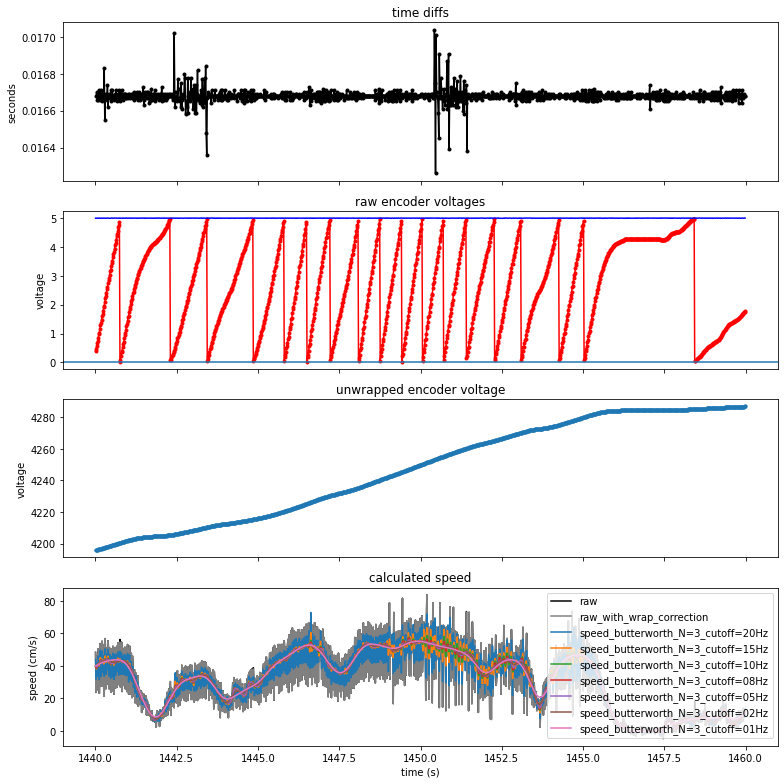

In [29]:
dft = running_df.query('time>=1440 and time <= 1460')
fig,ax = make_raw_plot(dft, figsize=(11,11))

legend = ['raw','raw_with_wrap_correction']
for filter_name in np.sort(filter_names)[::-1]:
    ax[3].plot(
        dft['time'],
        dft[filter_name],
    )
    legend.append(filter_name)
ax[3].legend(legend);
fig.tight_layout()

In [30]:
etr_df = get_combined_etr(session, running_df, filter_names)

p_value_df = get_p_values_at_each_timepoint(etr_df, groupby='speed_type', condition_1='hit', condition_2='correct_reject')

(<Figure size 792x792 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd72c2afa30>,
       dtype=object))

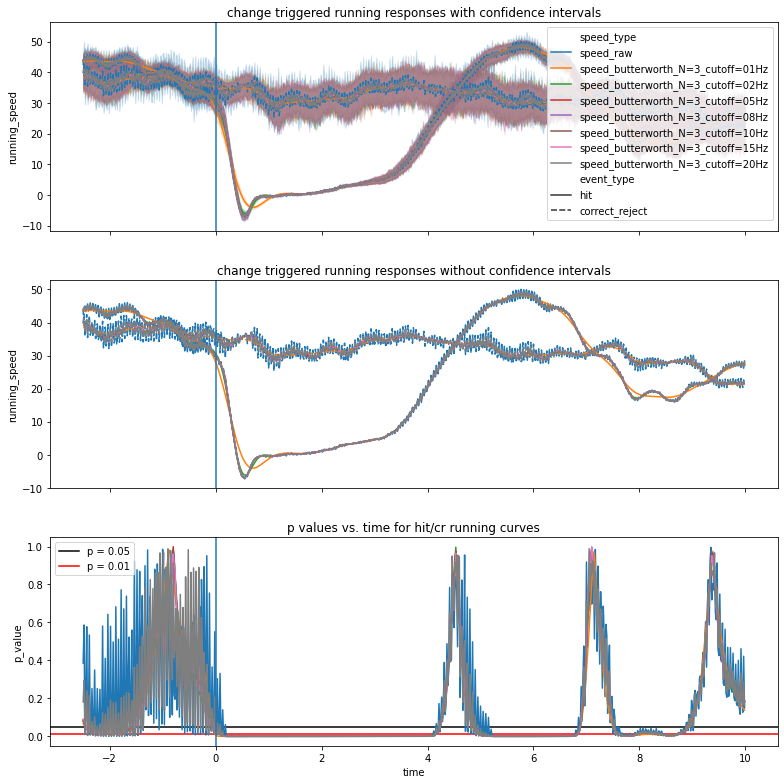

In [31]:
plot_change_triggered_responses(etr_df, p_value_df, time_range=(-2.5,10))

(<Figure size 792x792 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd72c2ccfd0>,
       dtype=object))

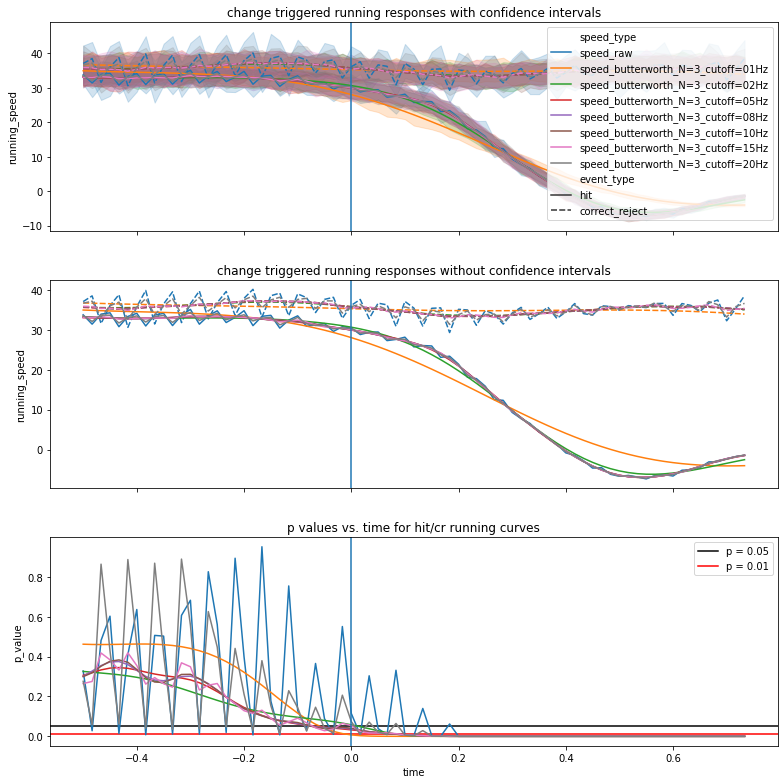

In [32]:
plot_change_triggered_responses(etr_df, p_value_df, time_range=(-0.5,0.75))

### another session

In [34]:
%%time
bsid = 853875514
session, running_df = load_session_and_running_df(bsid)
running_df = encoder_utilities.add_speed_acceleration_jerk(running_df, column_label='raw',v_max='v_sig_max')
running_df, filter_names = apply_filters(running_df)

CPU times: user 31.7 s, sys: 717 ms, total: 32.4 s
Wall time: 23.4 s


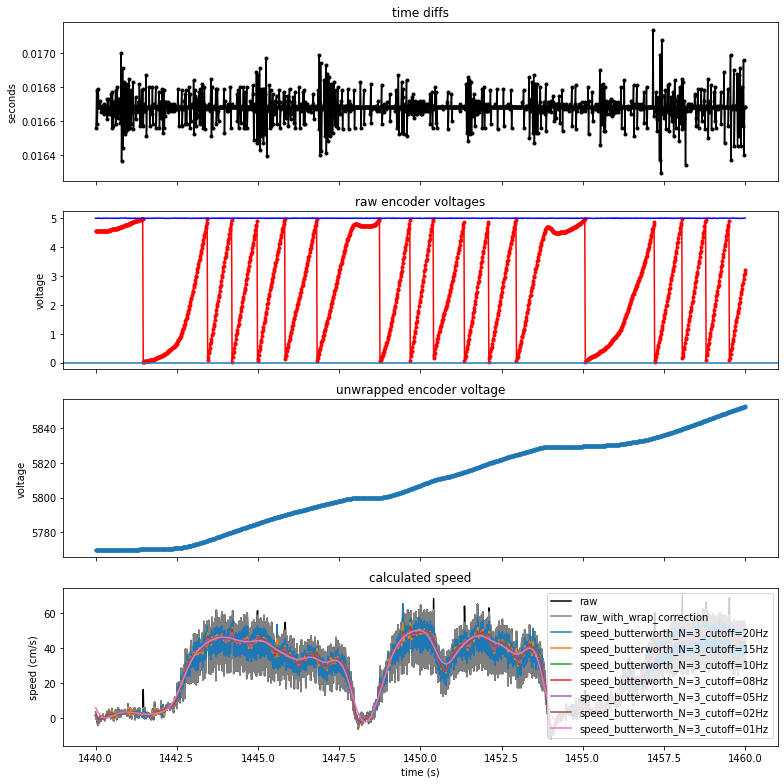

In [35]:
dft = running_df.query('time>=1440 and time <= 1460')
fig,ax = make_raw_plot(dft, figsize=(11,11))

legend = ['raw','raw_with_wrap_correction']
for filter_name in np.sort(filter_names)[::-1]:
    ax[3].plot(
        dft['time'],
        dft[filter_name],
    )
    legend.append(filter_name)
ax[3].legend(legend);
fig.tight_layout()

In [36]:
etr_df = get_combined_etr(session, running_df, filter_names)

%%time
p_value_df = get_p_values_at_each_timepoint(etr_df, groupby='speed_type', condition_1='hit', condition_2='correct_reject')

UsageError: Line magic function `%%time` not found.


(<Figure size 792x792 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6b6aa60a0>,
       dtype=object))

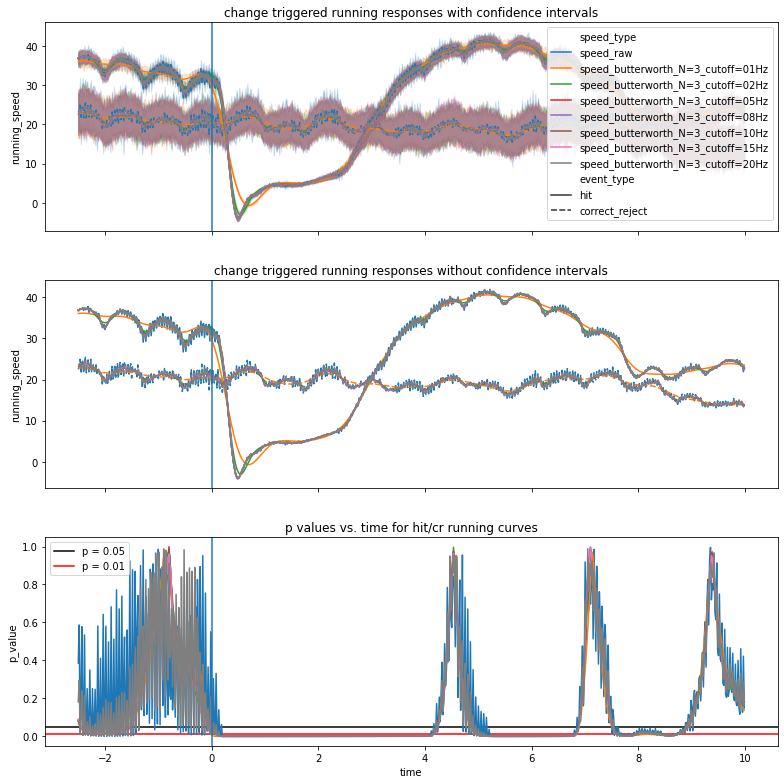

In [37]:
plot_change_triggered_responses(etr_df, p_value_df, time_range=(-2.5,10))

(<Figure size 792x792 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd700177250>,
       dtype=object))

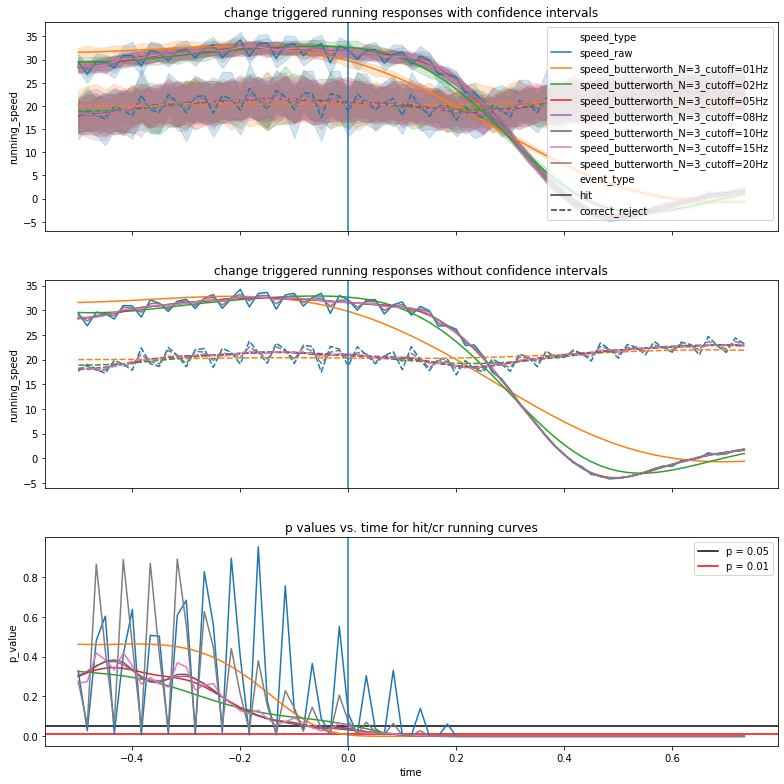

In [38]:
plot_change_triggered_responses(etr_df, p_value_df, time_range=(-0.5,0.75))

### and yet another
However, note that the this animal does not follow the typical pattern of running prior to the change, the slowing after. The interpretation of the event triggered average is therefore more difficult.

In [39]:
%%time
bsid = 929818797
session, running_df = load_session_and_running_df(bsid)
running_df = encoder_utilities.add_speed_acceleration_jerk(running_df, column_label='raw',v_max='v_sig_max')
running_df, filter_names = apply_filters(running_df)

CPU times: user 15.9 s, sys: 83.6 ms, total: 16 s
Wall time: 15.6 s


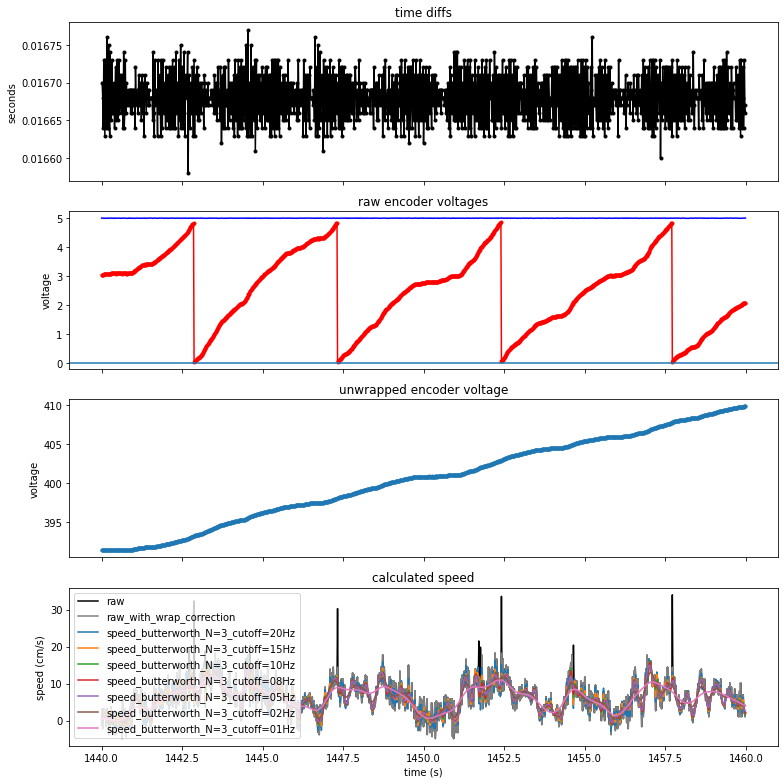

In [40]:
dft = running_df.query('time>=1440 and time <= 1460')
fig,ax = make_raw_plot(dft, figsize=(11,11))

legend = ['raw','raw_with_wrap_correction']
for filter_name in np.sort(filter_names)[::-1]:
    ax[3].plot(
        dft['time'],
        dft[filter_name],
    )
    legend.append(filter_name)
ax[3].legend(legend);
fig.tight_layout()

In [41]:
etr_df = get_combined_etr(session, running_df, filter_names)

p_value_df = get_p_values_at_each_timepoint(etr_df, groupby='speed_type', condition_1='hit', condition_2='correct_reject')

(<Figure size 792x792 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd725761370>,
       dtype=object))

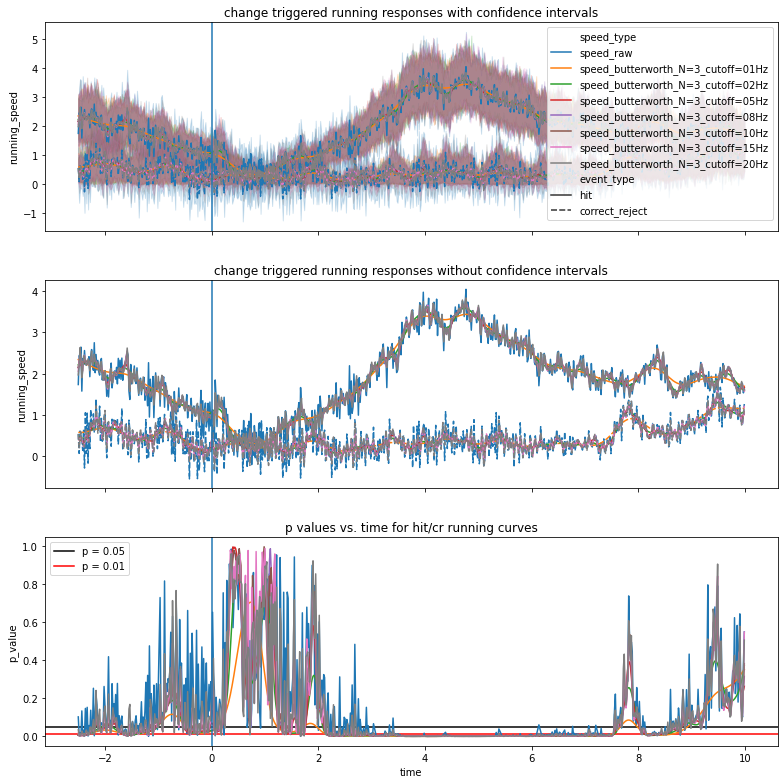

In [42]:
plot_change_triggered_responses(etr_df, p_value_df, time_range=(-2.5,10))

(<Figure size 792x792 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd72d3bffd0>,
       dtype=object))

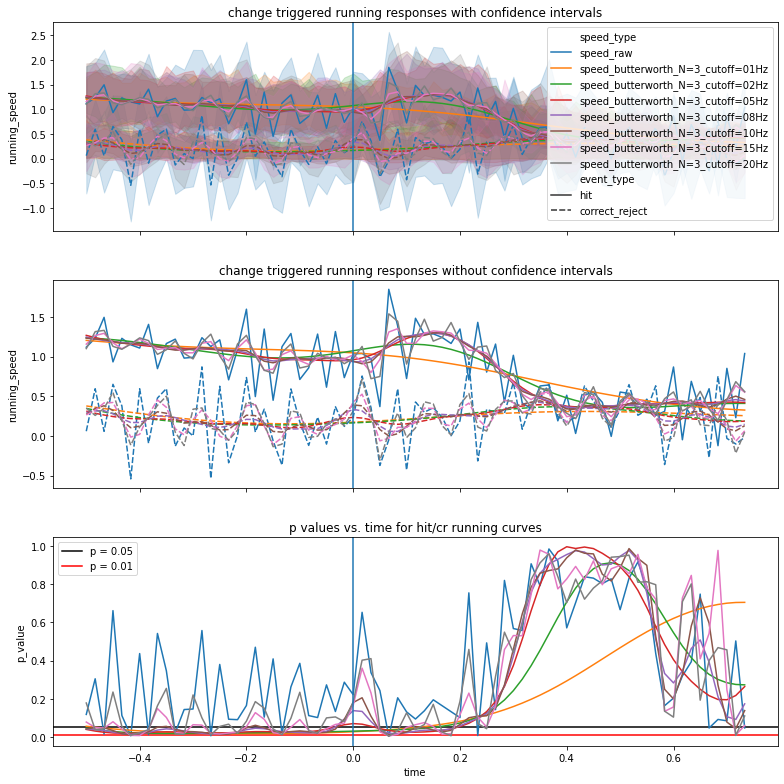

In [43]:
plot_change_triggered_responses(etr_df, p_value_df, time_range=(-0.5,0.75))

# Conclusion
In addition to the periodic noise in the voltage readings, the encoder voltages, and the derivates, do not appear stable at the crossings from 5V to 0V (the 'wraps'). Large spikes in the speed appear when taking the derivative at these crossings, along with occasional additional transients due to long frames. 

The spikes in voltage can be removed by:
* correcting using the max of the time-varying signal, instead of v_in. v_in dictates the max voltage the encoder could reach before wrapping to 0, but in practice, the max voltage is somewhat less. So using V_in over-estimates the change in voltage on that single timestep, which led to spike in speed.
* After calculating speed, removing outliers that occur at the wraps by constraining the speed at the wrap to be within the range of all other speeds in +/- 0.25 second window. This helps deal with the fact that even the previous step wasn’t enough to fully remove the transients.
* Performing one more outlier removal step where we set any speeds that vary by more than 5 SDs from the mean to NaN (this deals with occasional huge outliers that happen on long frames, where the acquisition computer looks to have hung).

After removing these outlier speed values, simple Butterworth lowpass filters with cutoff frequencies in the 5-10 Hz range appear to do a good job of both removing the oscillatory component of the voltage signal and tracking the speed changes of the mouse. With cutoff frequencies above 10 Hz, the oscillatory signal is not sufficiently filtered. For cutoff frequencies below 5 Hz, fast changes in running speed appear to be distorted, potentially leading to changes in data interpretation.

In [44]:
!which python

/usr/bin/python
